In [62]:
import pandas as pd
data = pd.read_csv("/content/car.csv" , delimiter=',', on_bad_lines='skip')

## There are tons of models to work with. The idea is to build all desired models in a single pipeline and evaluate to choose the best model

In [ ]:
brand_counts = data['brand'].value_counts(normalize=True)
top_brands = brand_counts[brand_counts.cumsum() <= 0.9]
top_brands

,proportion
brand,
Toyota,0.204872
Ford,0.153600
Hyundai,0.097534
Kia,0.096432
Mercedes Benz,0.070392
Mitsubishi,0.062707
Honda,0.057991
Mazda,0.053204
Chevrolet,0.031078


In [ ]:
data = data[data['brand'].isin(top_brands.index)]
data

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.000000,AT,petrol,white,23000,4.550000e+08,used
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,5.808429,AT,petrol,NaN,78545,2.950000e+08,used
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.000000,MT,petrol,white,99999,3.680000e+08,used
5,148583720,108712558,1694932494416,2022,Hyundai,Elantra,Việt Nam,Sedan,5.000000,AT,petrol,white,45000,4.550000e+08,used
6,150061598,109974620,1694955795249,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.000000,MT,petrol,white,60000,4.850000e+08,used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139763,150701823,110543836,1696513209000,2018,Ford,Fiesta,Việt Nam,Hatchback,5.000000,AT,petrol,NaN,39000,3.480000e+08,used
139764,143131229,104156088,1695820895703,2017,Ford,Explorer,Mỹ,SUV / Cross over,8.000000,AT,petrol,black,46000,9.990000e+08,used
139765,143131229,104156088,1695820895703,2017,Ford,Explorer,Mỹ,SUV / Cross over,8.000000,AT,petrol,black,46000,9.990000e+08,used
139766,148190686,108378656,1695345921929,2021,Ford,Ranger,NaN,Pick-up (bán tải),5.000000,AT,oil,NaN,10000,7.580000e+08,used


In [53]:
from sklearn.base import BaseEstimator, RegressorMixin
class XGBWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = XGBRegressor(**kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
categorical_features = ['brand', 'type', 'fuel', 'color', 'gearbox', 'origin']
numerical_features = ['mileage_v2', 'seats']
ordinal_features = ['condition']
target_column = 'price'


X = data[categorical_features + numerical_features + ordinal_features]
y = data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), #fill null value of numerical columns with median
    ('scaler', StandardScaler())            
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #fill null value of categorical columns with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    #convert to numerical values
])
#fill null value of ordinal columns with most frequent value
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #fill null value of ordinal columns with most frequent value
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)) 
])

#Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)

    ]
)

In [54]:
#train models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBWrapper(random_state=42)
}

# Evaluate
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    mae = -np.mean(scores)

    # Fit and test the model
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Metrics
    test_mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Save results
    results[model_name] = {
        'Cross-Validated MAE': mae,
        'Test MAE': test_mae,
        'RMSE': rmse,
        'R² Score': r2
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='Test MAE'))


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

                   Cross-Validated MAE      Test MAE          RMSE  R² Score
Random Forest             3.547554e+07  3.294056e+07  1.083738e+08  0.958452
XGBoost                   1.027213e+08  1.017126e+08  1.854550e+08  0.878332
Linear Regression         2.159529e+08  2.185808e+08  4.169126e+08  0.385122


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Random Forest is the best-performing model.
Since lowest MAE and highest R² indicate that the model fits the data best and makes most accurate predictions.

Create a separate pipeline for preprocessing and Random Forest model only for later use

In [56]:
import joblib

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing pipeline
    ('model', models['Random Forest'])  # Random Forest model
])

# save the rf model
joblib.dump(pipeline, 'random_forest_pipeline.pkl')
print("Random Forest model saved successfully!")

Random Forest model saved successfully!


## Data Analysis

4. **(Bonus Points) Data Analysis Questions**
    
    Answer the following questions based on the provided dataset:
    
    - How does mileage relate to car price? Is there a clear negative correlation?
    - Does the fuel type (petrol, diesel, etc.) have a noticeable impact on price?
    - How to compare two cars in the same segment?

In [66]:
import matplotlib.pyplot as plt

correlation = data['mileage_v2'].corr(data['price'])
print(f"Correlation: {correlation}")

Correlation: -0.19152412058872723


It shows that there is a weak or non linear relationship between the total distance that a car travels (Mileage) and price.

Correlation: -0.19152412058872723 indicates a very weak negative correlation as Mileage increases then price tends to decrease very slightly

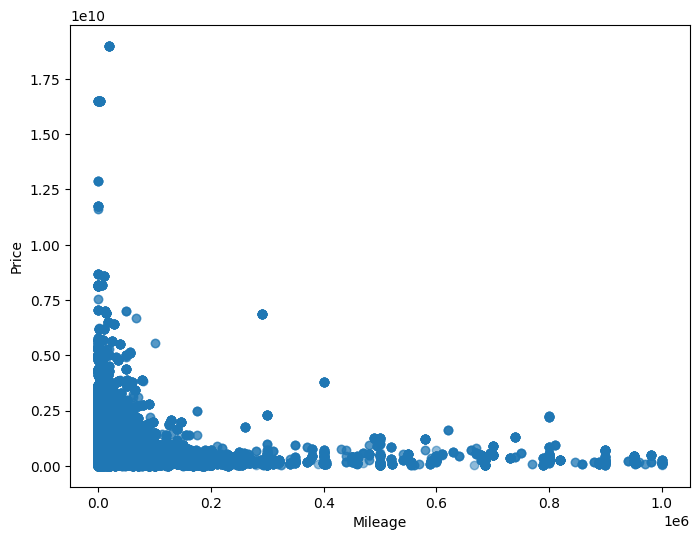

In [69]:
plt.figure(figsize=(8, 6))
plt.scatter(data['mileage_v2'], data['price'], alpha=0.5)
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.show()

In the scatter plot

2. Does the fuel type (petrol, diesel, etc.) have a noticeable impact on price?
   
        Here I use ANOVA table to examine the impact of categorical var to numerical variable

In [59]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
#OLS model
model = ols('price ~ C(brand)', data=data).fit()

#ANOVA table
print(anova_lm(model, typ=1))

                df        sum_sq       mean_sq            F  PR(>F)
C(brand)      11.0  8.114496e+21  7.376814e+20  3414.193408     0.0
Residual  125030.0  2.701438e+22  2.160632e+17          NaN     NaN


F-value with very high value shows that there is a significant influence of brand on price

Sum of Square error shows that total variabilty in the price is highly explained by brand   

--> Both shows there is a significant impact of brand on selling price.